# TFM - Predicción potenciales compradores de un ecommerce

------------------------------------

------------------

### 1.1 Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier

from xgboost import XGBClassifier

from collections import Counter

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

------------------

### 1.2 Variables globales

In [2]:
LABELS = ["No_Cliente","Cliente"]

------------------

### 1.3 Funciones

In [3]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

------------------------------------

------------------

A continuación comenzamos leyendo los ficheros que hemos tratado, limpiado y analizado en los procesos anteriores.

Se realizará un análisis sencillo de la estructura y una visualización de varias muestras. 

Además someteremos las variables categóricas a variables *dummies*, de forma que que podamos introducirlas ennuestro modelo.

### 2.1 Lectura de Fichero

In [4]:
df = pd.read_csv('Data/dataset_model_corr.txt', sep = ';', encoding = 'ISO-8859-1')

In [5]:
df.shape

(406267, 26)

In [6]:
df.head(3)

,TIPOUSUARIO,FECHA_REGISTRO_WEEKDAY,FECHA_REGISTRO_MONTH,CANAL_REGISTRO,TIPOEMAIL,BONDAD_EMAIL,TIPO_TELF,IP_CONTINENTE,IP_COUNTRY_PIB,USU_TIPO,USU_TAMANIO,USU_ESTADO,USU_SECTOR_ECONOMICO,1A_DESCGRUPOPROD,1A_EMPCONSUL_EST,1A_EMPCONSUL_SECTOR,IPCASOS,IP_COUNTRY_IDH_NUM,USU_DEPART_DEN_POB,USU_DEPART_IDH,1A_EMPCONSUL_PROV_DENS,1A_EMPCONSUL_PROV_IDH,FICH_PROMO_TOT,PERF_PROMO_TOT,IND_ALTA,IND_CLIENTE
0,PF,1,10,3,GOOHOTYAHMAIL,0,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,NoApl,NoApl,NoApl,NoApl,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,-1.00,-1.000,47.92,0.782,0,1,0,0
1,PJ,1,5,3,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,PQ,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,SD,1,0.767,306.38,0.832,47.92,0.782,0,1,0,0
2,PJ,2,9,7,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,MC,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,815.17,0.835,4438.75,0.904,0,1,0,0


------------------

### 2.2 Variables dummies

In [7]:
ohe_columns = ['TIPOUSUARIO','FECHA_REGISTRO_WEEKDAY','FECHA_REGISTRO_MONTH','CANAL_REGISTRO','TIPOEMAIL','TIPO_TELF','IP_CONTINENTE','IP_COUNTRY_PIB','USU_TIPO',
               'USU_TAMANIO','USU_ESTADO','USU_SECTOR_ECONOMICO','1A_DESCGRUPOPROD','1A_EMPCONSUL_EST','1A_EMPCONSUL_SECTOR']

In [8]:
final_df = pd.get_dummies(df, columns = ohe_columns)

**Columnas para la predicción**

In [9]:
columnas = ['TIPOUSUARIO_PF','TIPOUSUARIO_PJ', 'FECHA_REGISTRO_WEEKDAY_0','FECHA_REGISTRO_WEEKDAY_1', 'FECHA_REGISTRO_WEEKDAY_2','FECHA_REGISTRO_WEEKDAY_3', 
            'FECHA_REGISTRO_WEEKDAY_4','FECHA_REGISTRO_WEEKDAY_5', 'FECHA_REGISTRO_WEEKDAY_6','FECHA_REGISTRO_MONTH_1', 'FECHA_REGISTRO_MONTH_2',
            'FECHA_REGISTRO_MONTH_3', 'FECHA_REGISTRO_MONTH_4','FECHA_REGISTRO_MONTH_5', 'FECHA_REGISTRO_MONTH_6','FECHA_REGISTRO_MONTH_7', 'FECHA_REGISTRO_MONTH_8',
            'FECHA_REGISTRO_MONTH_9', 'FECHA_REGISTRO_MONTH_10','FECHA_REGISTRO_MONTH_11', 'FECHA_REGISTRO_MONTH_12','CANAL_REGISTRO_1', 'CANAL_REGISTRO_2', 'CANAL_REGISTRO_3',
            'CANAL_REGISTRO_4', 'CANAL_REGISTRO_5', 'CANAL_REGISTRO_6', 'CANAL_REGISTRO_7', 'CANAL_REGISTRO_8', 'CANAL_REGISTRO_9','TIPOEMAIL_ADMINISTRACION','TIPOEMAIL_CORPORATIVO',
            'TIPOEMAIL_DOCENTE','TIPOEMAIL_GOOHOTYAHMAIL','TIPOEMAIL_SINCLASIFICAR','TIPOEMAIL_TEMPORAL','BONDAD_EMAIL','IPCASOS','TIPO_TELF_EXTRANJERO',
            'TIPO_TELF_MOVIL', 'TIPO_TELF_NO_PUBLICO','IP_CONTINENTE_AFRICA','IP_CONTINENTE_AMERICA_NORTE','IP_CONTINENTE_AMERICA_SUR','IP_CONTINENTE_ASIA','IP_CONTINENTE_EUROPA',
            'IP_CONTINENTE_NI','IP_CONTINENTE_OCEANNIA', 'IP_COUNTRY_PIB_Ingreso alto','IP_COUNTRY_PIB_Ingreso mediano alto','IP_COUNTRY_PIB_NI',
            'IP_COUNTRY_PIB_Países de ingreso mediano bajo','IP_COUNTRY_IDH_NUM', 'USU_TIPO_EMPRESARIO INDIVIDUAL','USU_TIPO_ENTIDAD_HOLDING','USU_TIPO_NI','USU_TIPO_NoApl',
            'USU_TIPO_SOC_COMERCIAL_INDUSTRIAL','USU_TIPO_SOC_NO_COMERCIAL','USU_TAMANIO_GR', 'USU_TAMANIO_MC','USU_TAMANIO_MD','USU_TAMANIO_NoApl','USU_TAMANIO_PQ',
            'USU_TAMANIO_SD','USU_ESTADO_ACTIVA','USU_ESTADO_INACTIVA','USU_ESTADO_NoApl', 'USU_ESTADO_REESTRUCTURACION','USU_ESTADO_RELACION_CLINTON','USU_ESTADO_SD',
            'USU_SECTOR_ECONOMICO_CUATERNARIO','USU_SECTOR_ECONOMICO_NoApl', 'USU_SECTOR_ECONOMICO_PRIMARIO','USU_SECTOR_ECONOMICO_QUINARIO','USU_SECTOR_ECONOMICO_SD',
            'USU_SECTOR_ECONOMICO_SECUNDARIO','USU_SECTOR_ECONOMICO_TERCIARIO', 'USU_DEPART_DEN_POB','USU_DEPART_IDH','FICH_PROMO_TOT','PERF_PROMO_TOT','1A_EMPCONSUL_EST_ACTIVA', 
            '1A_EMPCONSUL_EST_INACTIVA', '1A_DESCGRUPOPROD_FICH_PROMO', '1A_DESCGRUPOPROD_PERF_PROMO', '1A_DESCGRUPOPROD_RES_PAGO', '1A_EMPCONSUL_EST_NI', 
            '1A_EMPCONSUL_EST_REESTRUCTURACION', '1A_EMPCONSUL_EST_RELACION_CLINTON', '1A_EMPCONSUL_SECTOR_CUATERNARIO', '1A_EMPCONSUL_SECTOR_PRIMARIO', '1A_EMPCONSUL_SECTOR_QUINARIO',
            '1A_EMPCONSUL_SECTOR_SD', '1A_EMPCONSUL_SECTOR_SECUNDARIO', '1A_EMPCONSUL_SECTOR_TERCIARIO']

-----------------

------------------

### 3.1 Analisis desbalanceo

In [10]:
final_df.shape

(406267, 100)

In [11]:
pd.value_counts(final_df['IND_CLIENTE'], sort = True)

0    395427
1     10840
Name: IND_CLIENTE, dtype: int64

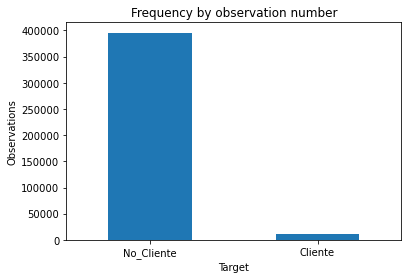

In [12]:
count_classes = pd.value_counts(final_df['IND_CLIENTE'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Target")
plt.ylabel("Observations");

In [13]:
print('Los clientes suponen un % del total: ', (10840/final_df.shape[0])*100)

Los clientes suponen un % del total:  2.668196038565771


**Podemos ver un claro desbalanceo donde los clientes no suponen más del 3% de las observaciones**

------------------

------------------

### 4. Creación del Modelo

#### 4.1 Dividimos el set entre features y label

In [14]:
features = final_df[columnas]
labels = final_df['IND_CLIENTE']

In [15]:
features.shape

(406267, 96)

In [16]:
labels.shape

(406267,)

------------------

#### 4.2 Creamos set de entrenamiento y test

In [17]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [18]:
train_x.shape

(284386, 96)

In [19]:
test_x.shape

(121881, 96)

In [20]:
train_y.shape

(284386,)

In [21]:
test_y.shape

(121881,)

--------------

--------------

#### 4.3 Modelo 1 - Baseline

Nuestro modelo Base, tendrá los parámetros obtenidos como mejores anteriormente.

**Aplicamos los mejores hiperparámetros obtenidos**

In [51]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [52]:
clf.fit(train_x, train_y)

[23:53:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=8
[23:53:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=8
[23:53:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[23:53:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=8
[23:53:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=8
[23:53:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=8
[23:53:01] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=8
[23:53:01] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=8
[23:53:01] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

Observamos los resultados del modelo

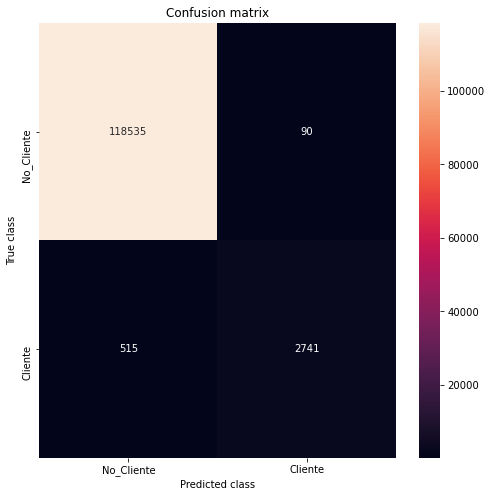

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118625
           1       0.97      0.84      0.90      3256

    accuracy                           1.00    121881
   macro avg       0.98      0.92      0.95    121881
weighted avg       0.99      1.00      0.99    121881



In [53]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [54]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [55]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IP_COUNTRY_PIB_NI,9.770191
BONDAD_EMAIL,5.361543
USU_ESTADO_ACTIVA,4.749950
USU_TAMANIO_SD,3.240775
CANAL_REGISTRO_4,3.133674
1A_DESCGRUPOPROD_PERF_PROMO,2.920129
FICH_PROMO_TOT,2.907022
1A_DESCGRUPOPROD_RES_PAGO,2.835404
TIPOEMAIL_TEMPORAL,2.580224
IP_CONTINENTE_ASIA,2.523010


In [56]:
feature_importances[feature_importances['important'] > 0.01].shape

(26, 1)

------

------

------

#### 4.4 Modelo - Aplicando técnicas sobre el desbalanceo

**Estrategias para el manejo de Datos Desbalanceados**

##### **4.4.1 Subsampling en la clase mayoritaria**

**RandomUnderSampler**

In [57]:
us = RandomUnderSampler(sampling_strategy = 'majority', random_state = 123)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 276802, 1: 7584})
Distribution after resampling Counter({0: 7584, 1: 7584})


In [58]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [59]:
clf.fit(X_train_res, y_train_res)

[23:55:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=8
[23:55:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=8
[23:55:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=8
[23:55:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=8
[23:55:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=8
[23:55:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=8
[23:55:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=8
[23:55:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=8
[23:55:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

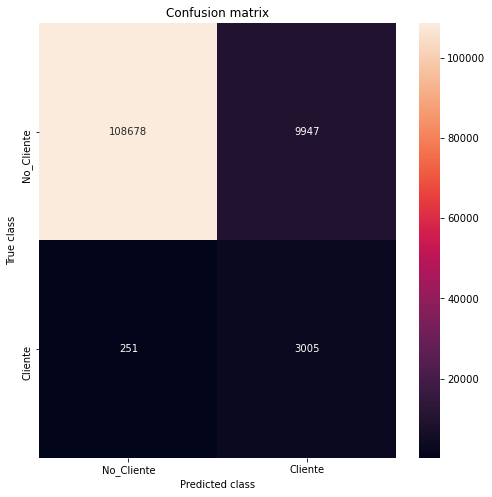

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    118625
           1       0.23      0.92      0.37      3256

    accuracy                           0.92    121881
   macro avg       0.61      0.92      0.66    121881
weighted avg       0.98      0.92      0.94    121881



In [60]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [61]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [62]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IP_COUNTRY_PIB_Ingreso mediano alto,9.447399
IP_COUNTRY_PIB_NI,8.654170
BONDAD_EMAIL,6.950483
USU_ESTADO_NoApl,5.613653
1A_DESCGRUPOPROD_PERF_PROMO,5.369519
TIPOEMAIL_TEMPORAL,4.790660
USU_DEPART_IDH,4.230872
FICH_PROMO_TOT,3.963524
USU_TAMANIO_SD,2.245868
1A_DESCGRUPOPROD_RES_PAGO,1.955364


In [63]:
feature_importances[feature_importances['important'] > 0.01].shape

(17, 1)

------

##### **4.4.2 Oversampling en la clase minoritaria**

**SMOTE**

In [64]:
os =  SMOTE(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [65]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 276802, 1: 7584})
Distribution labels after resampling Counter({1: 276802, 0: 276802})


In [66]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [67]:
clf.fit(X_train_res, y_train_res)

[23:56:22] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[23:56:22] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[23:56:23] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=8
[23:56:23] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[23:56:23] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=8
[23:56:24] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=8
[23:56:24] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[23:56:24] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=8
[23:56:24] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 296 extra nodes, 0 

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

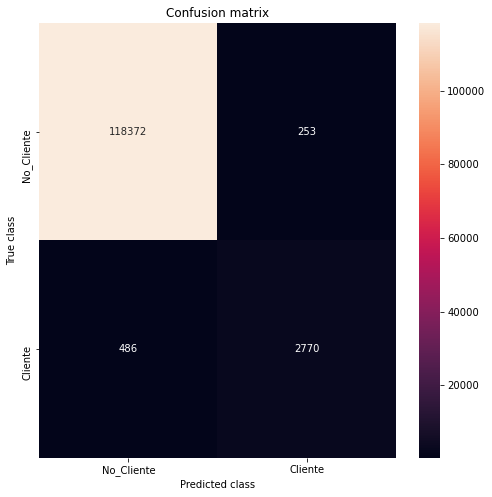

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118625
           1       0.92      0.85      0.88      3256

    accuracy                           0.99    121881
   macro avg       0.96      0.92      0.94    121881
weighted avg       0.99      0.99      0.99    121881



In [68]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [69]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [70]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_ESTADO_NoApl,14.333510
TIPOEMAIL_TEMPORAL,7.508034
IP_COUNTRY_PIB_Ingreso mediano alto,6.386897
USU_TAMANIO_SD,5.891047
BONDAD_EMAIL,4.295175
1A_DESCGRUPOPROD_PERF_PROMO,4.152380
USU_DEPART_DEN_POB,3.244887
FICH_PROMO_TOT,2.565349
IP_COUNTRY_PIB_NI,2.465017
CANAL_REGISTRO_5,2.073763


In [71]:
feature_importances[feature_importances['important'] > 0.01].shape

(21, 1)

------

##### **4.4.3 Combinamos OverSampling con Subsampling**

**Combinando SMOTE & RandomUnderSampler**

In [72]:
over = SMOTE(sampling_strategy = 0.3)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [73]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [74]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 276802, 1: 7584})
Distribution after resampling Counter({0: 166080, 1: 83040})


In [75]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [76]:
clf.fit(X_train_res, y_train_res)

[23:59:10] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[23:59:10] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=8
[23:59:10] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=8
[23:59:10] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[23:59:10] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=8
[23:59:11] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=8
[23:59:11] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[23:59:11] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[23:59:11] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

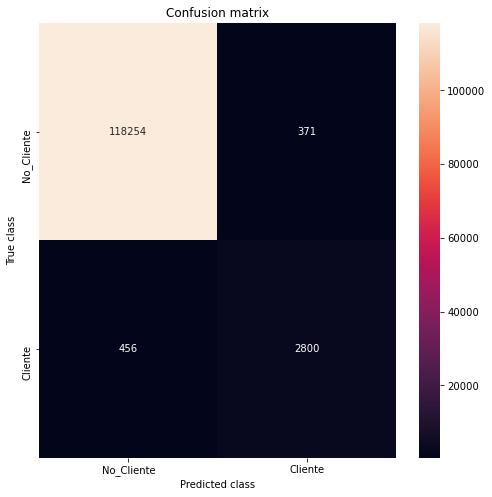

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118625
           1       0.88      0.86      0.87      3256

    accuracy                           0.99    121881
   macro avg       0.94      0.93      0.93    121881
weighted avg       0.99      0.99      0.99    121881



In [77]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [78]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [79]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_ESTADO_NoApl,7.978367
TIPOEMAIL_TEMPORAL,6.211488
IP_COUNTRY_PIB_Ingreso mediano alto,5.852517
1A_DESCGRUPOPROD_PERF_PROMO,5.662922
BONDAD_EMAIL,4.853000
IP_COUNTRY_PIB_NI,4.800539
USU_TAMANIO_SD,4.474925
USU_DEPART_DEN_POB,3.154947
FICH_PROMO_TOT,2.751088
IP_COUNTRY_PIB_Ingreso alto,2.190335


In [80]:
feature_importances[feature_importances['important'] > 0.01].shape

(25, 1)

------

**SMOTETomek**

In [81]:
os_us = SMOTETomek(sampling_strategy = 'all')
X_train_res, y_train_res = os_us.fit_resample(train_x, train_y)

In [82]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 276802, 1: 7584})
Distribution after resampling Counter({1: 276790, 0: 276790})


In [83]:
clf = XGBClassifier(eval_metric = 'error', objective = 'binary:logistic', colsample_bytree = 0.6, learning_rate = 0.5, max_depth = 8, alpha = 0, n_estimators = 320, random_state = 123)

In [84]:
clf.fit(X_train_res, y_train_res)

[01:14:59] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[01:14:59] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[01:14:59] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=8
[01:15:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=8
[01:15:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[01:15:00] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=8
[01:15:01] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[01:15:01] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[01:15:01] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=320, n_jobs=12,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

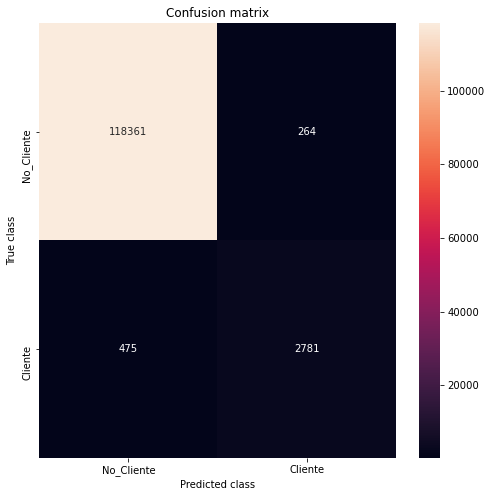

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118625
           1       0.91      0.85      0.88      3256

    accuracy                           0.99    121881
   macro avg       0.95      0.93      0.94    121881
weighted avg       0.99      0.99      0.99    121881



In [85]:
pred_y = clf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [86]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [87]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_ESTADO_NoApl,14.002962
TIPOEMAIL_TEMPORAL,6.647213
IP_COUNTRY_PIB_Ingreso mediano alto,6.584677
USU_TAMANIO_SD,4.612123
1A_DESCGRUPOPROD_PERF_PROMO,4.383744
BONDAD_EMAIL,4.047440
USU_DEPART_DEN_POB,3.169371
FICH_PROMO_TOT,2.594720
IP_COUNTRY_PIB_NI,2.176828
CANAL_REGISTRO_5,2.073200


In [88]:
feature_importances[feature_importances['important'] > 0.01].shape

(24, 1)